# **Lab 1 Pruning MobileNetV2**

### Goals

In this assignment, you will practice pruning a classical neural network model to reduce both model size and latency. The goals of this assignment are as follows:

- Understand the basic concept of **pruning**
- Implement and apply **fine-grained pruning**
- Implement and apply **channel pruning**
- Get a basic understanding of performance improvement (such as speedup) from pruning
- Understand the differences and tradeoffs between these pruning approaches

### Contents


There are two main sections in this lab: ***Fine-grained Pruning*** and ***Channel Pruning***.

- For part 1, we will learn about *Fine-grained Pruning*, there are ***5*** questions (Question 1-5).
- For part 2, we will apply *Channel Pruning* to observe speedup on inference

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and mobilenetV2 network which is the same as what we used in the Lab 0 tutorial.

In [1]:
print('Installing torchprofile...')
!pip install torchprofile #1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [1]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
# from torchvision.datasets import *
# from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [2]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [3]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [10]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [8]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Load the pretrained model and the CIFAR-10 dataset.

In [9]:
model = torch.load("./mobilenetv2_0.963.pth", map_location="cpu", weights_only=False)
model.cuda()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [46]:
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10

transform = {
    "train": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transform[split],
  )

# You can apply your own batch_size
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=64,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
    drop_last=True
  )

Files already downloaded and verified
Files already downloaded and verified


# Let's First Evaluate the Accuracy and Model Size of Dense Model.

 Neural networks have become ubiquitous in many applications. Here we have loaded a pretrained MobileNetV2 model for classifying images in CIFAR10 dataset.

Let's first evaluate the accuracy and model size of this model.

In [9]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/156 [00:00<?, ?it/s]

dense model has accuracy=96.30%
dense model has size=8.53 MiB


While large neural networks are very powerful, their size consumes considerable storage, memory bandwidth, and computational resources.
As we can see from the results above, a model for the task as simple as classifying $224\times224$ images into 10 classes can be as large as 8.5 MiB.
For embedded mobile applications, these resource demands become prohibitive.

Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.

The goal of pruning is to reduce the model size while maintaining the accuracy.

# Let's see the distribution of weight values

Before we jump into pruning, let's see the distribution of weight values in the dense model.

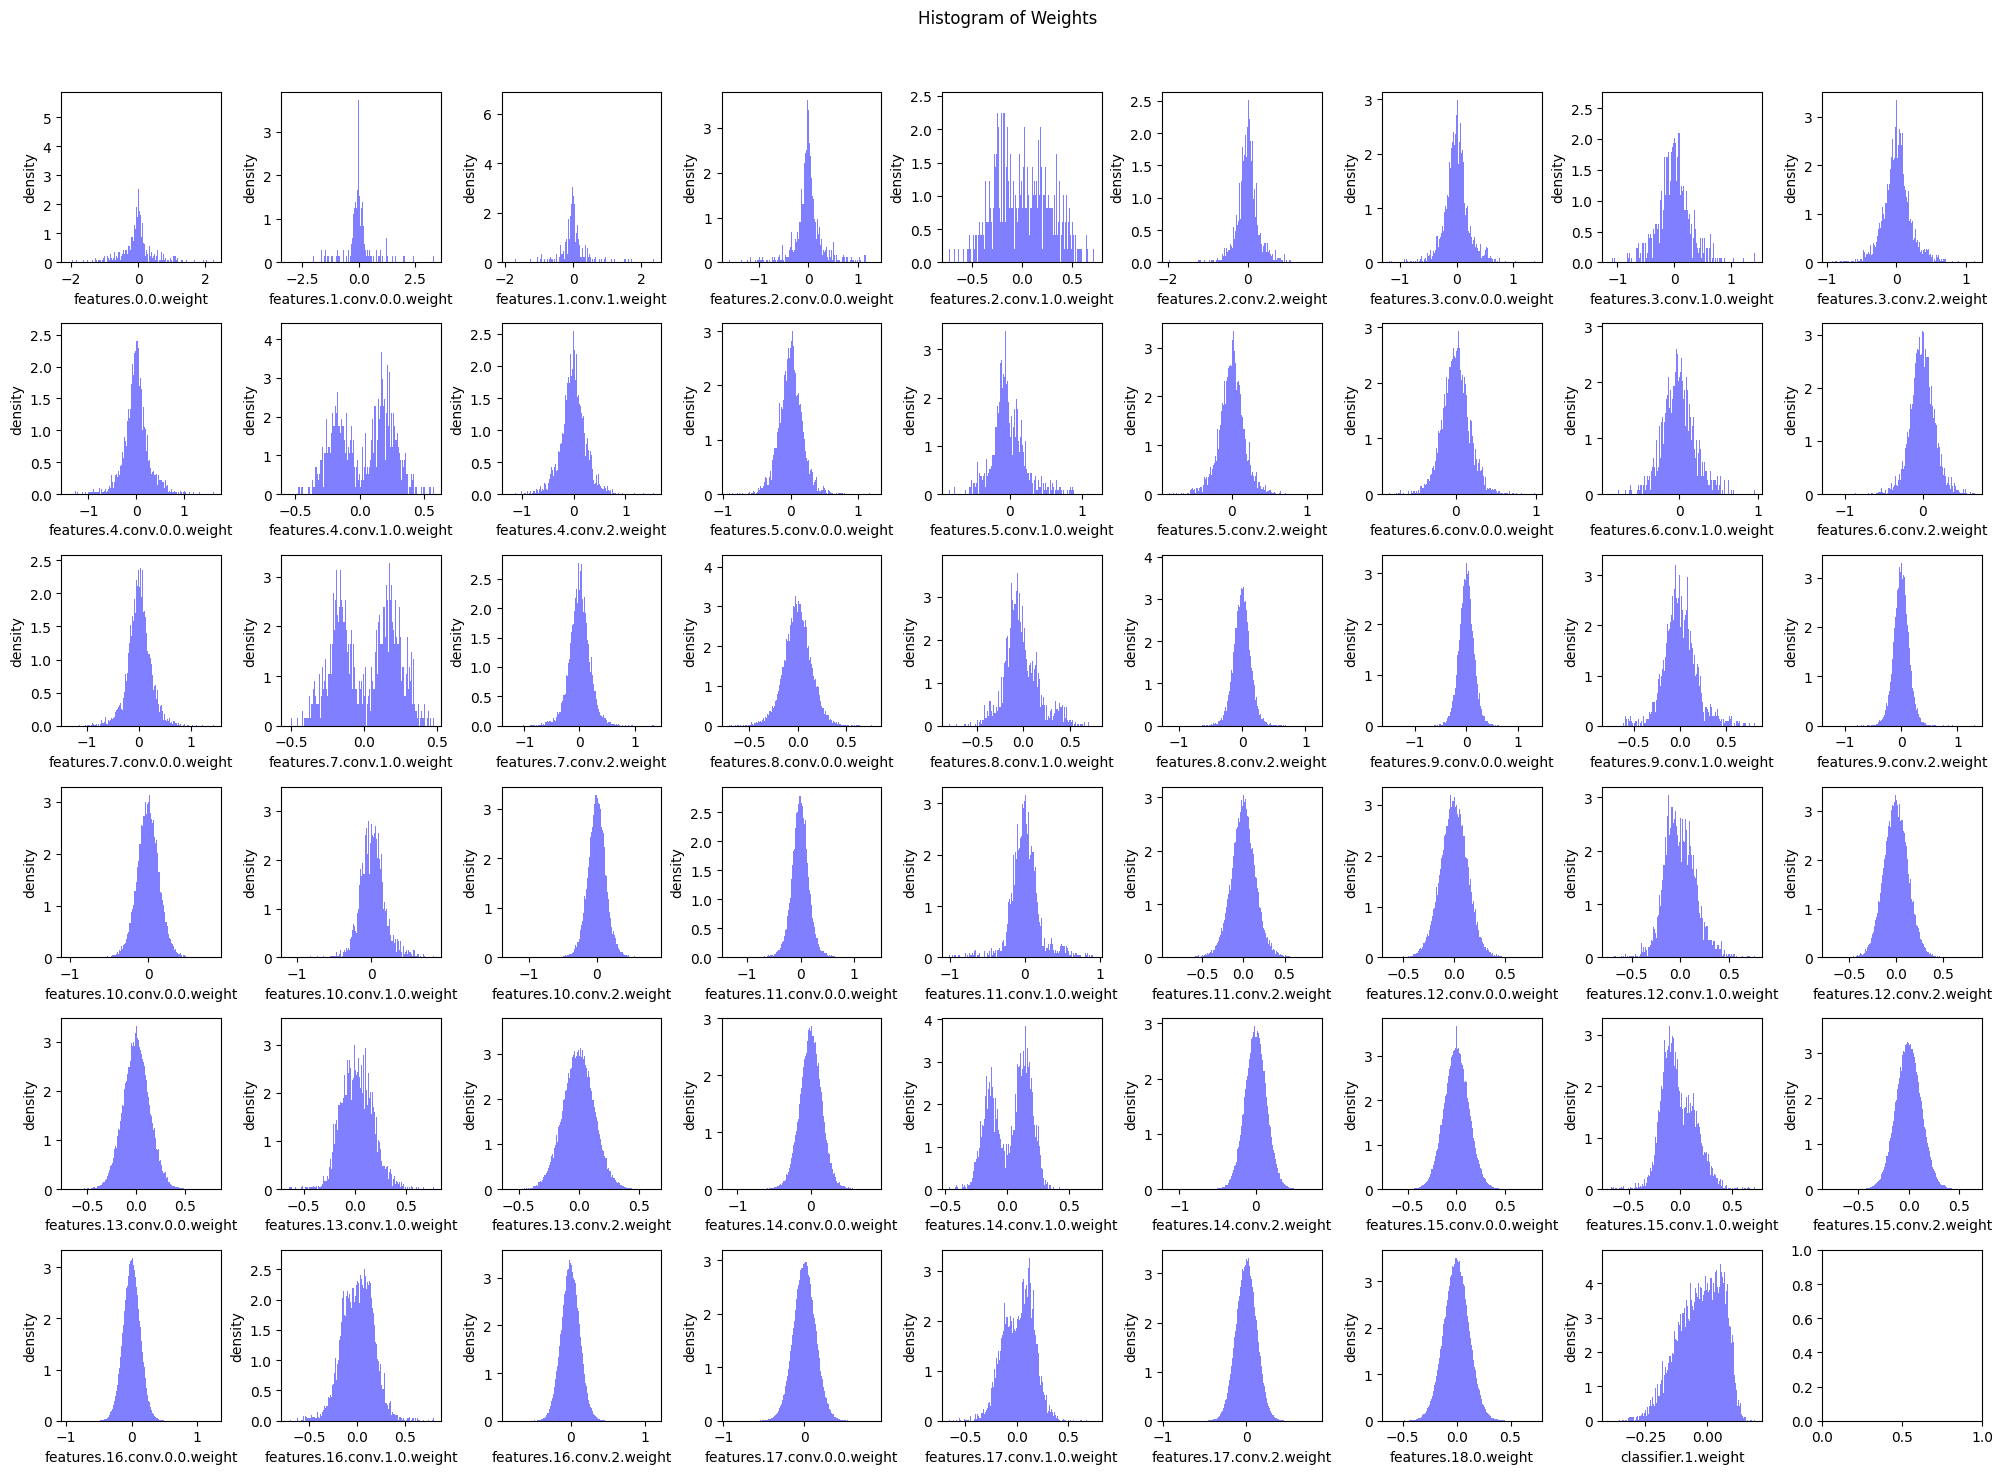

In [10]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(6, 9, figsize=(20, 15))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

## Question 1 (5%)

Please answer the following questions using the information in the above histograms of weights.


### Question 1.1 (2%)

What are the common characteristics of the weight distribution in the different layers?

**Your Answer:**  Most weight distributions are roughly Gaussian (normal), centered around zero.

### Question 1.2  (3%)

How does these characteristics help pruning?

**Your Answer:** Many weights are close to zero, contributing little to the network's output and can be pruned with minimal impact on performance.

# Part 1: Fine-grained Pruning (Unstructered Pruning)

In this section, we will implement and perform fine-grained pruning.

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.

## Magnitude-based Pruning

For fine-grained pruning, a widely-used importance is the magnitude of weight value, *i.e.*,

$Importance=|W|$

This is known as **Magnitude-based Pruning** (see [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

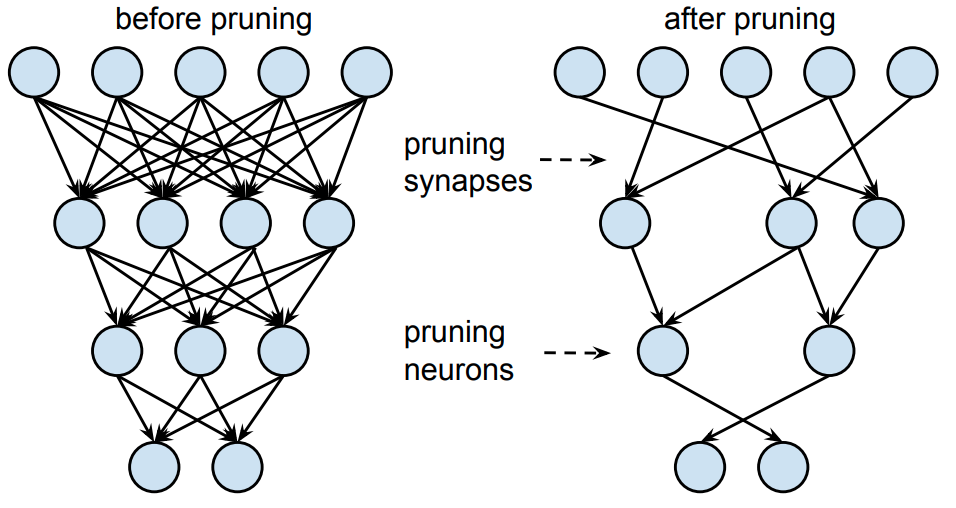

### Question 2 (15 pts)

Please complete the following magnitude-based fine-grained pruning function.

**Hint**:
*   In step 1, we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.
*   In step 2, we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.
*   In step 3, we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.
*   In step 4, we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [35]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """

    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(sparsity * num_elements)

    # Step 2: calculate the importance of weight
    importance = tensor.abs()

    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.view(-1), num_zeros).values

    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance.gt(threshold)

    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

Let's verify the functionality of defined fine-grained pruning by applying the function above on a dummy tensor.

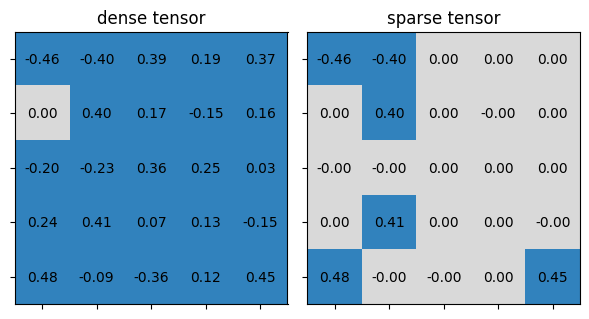

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [36]:
test_fine_grained_prune()

### Question 3 (5 pts)

The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

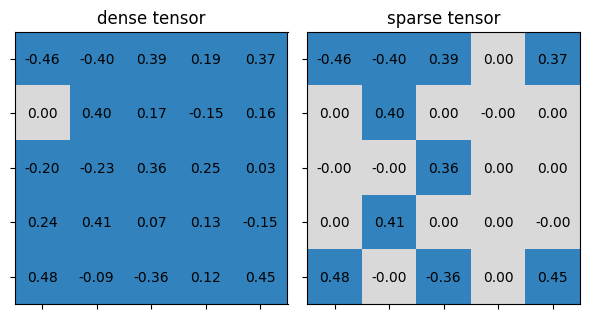

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [37]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = 0.6
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class `FineGrainedPruner`, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [38]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy. (This is Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))


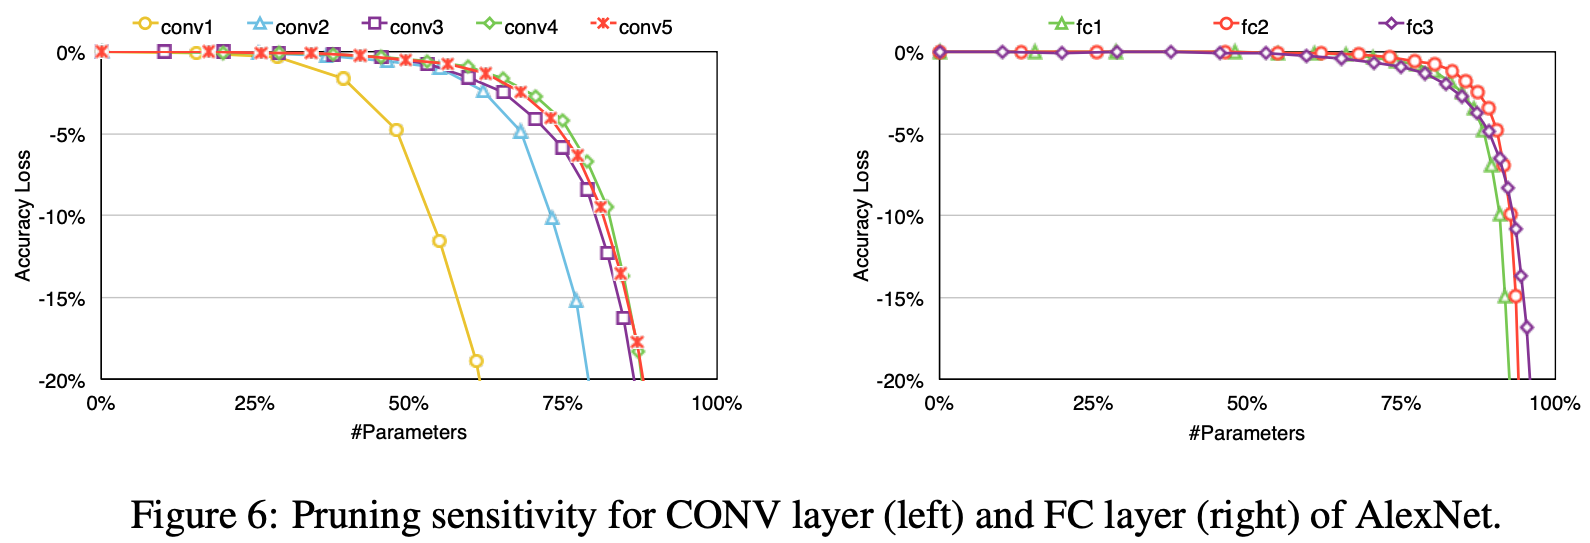

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.

In [39]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]

    for i_layer, (name, param) in enumerate(named_conv_weights):

        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

Please run the following cells to plot the sensitivity curves. You can run through different sparsities and check sensitivity.

In [40]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.2, scan_start=0.5, scan_end=1.0)

scanning 0/53 weight - features.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.92%, 93.70%, 72.89%]

scanning 1/53 weight - features.1.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[83.29%, 55.92%, 46.88%]

scanning 2/53 weight - features.1.conv.1.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.95%, 91.89%, 40.97%]

scanning 3/53 weight - features.2.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.11%, 95.94%, 91.82%]

scanning 4/53 weight - features.2.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[86.53%, 43.03%, 14.65%]

scanning 5/53 weight - features.2.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.41%, 91.33%, 16.72%]

scanning 6/53 weight - features.3.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.26%, 96.09%, 94.91%]

scanning 7/53 weight - features.3.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.43%, 87.76%, 49.66%]

scanning 8/53 weight - features.3.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.89%, 92.11%, 81.82%]

scanning 9/53 weight - features.4.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.20%, 95.83%, 87.71%]

scanning 10/53 weight - features.4.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.08%, 90.97%, 34.46%]

scanning 11/53 weight - features.4.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.42%, 85.85%, 31.73%]

scanning 12/53 weight - features.5.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.19%, 96.20%, 95.60%]

scanning 13/53 weight - features.5.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[90.58%, 66.58%, 19.34%]

scanning 14/53 weight - features.5.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.07%, 93.78%, 92.58%]

scanning 15/53 weight - features.6.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.21%, 96.23%, 95.88%]

scanning 16/53 weight - features.6.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[94.51%, 83.89%, 45.37%]

scanning 17/53 weight - features.6.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.12%, 94.87%, 87.60%]

scanning 18/53 weight - features.7.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.02%, 95.60%, 90.13%]

scanning 19/53 weight - features.7.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.44%, 93.01%, 22.04%]

scanning 20/53 weight - features.7.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[93.99%, 86.51%, 29.56%]

scanning 21/53 weight - features.8.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.31%, 96.25%, 95.65%]

scanning 22/53 weight - features.8.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[94.70%, 94.20%, 24.54%]

scanning 23/53 weight - features.8.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.97%, 95.34%, 94.10%]

scanning 24/53 weight - features.9.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.23%, 96.04%, 95.67%]

scanning 25/53 weight - features.9.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.07%, 94.50%, 89.76%]

scanning 26/53 weight - features.9.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.91%, 95.61%, 92.71%]

scanning 27/53 weight - features.10.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.12%, 96.09%, 95.87%]

scanning 28/53 weight - features.10.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.89%, 95.53%, 92.45%]

scanning 29/53 weight - features.10.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.17%, 95.42%, 93.79%]

scanning 30/53 weight - features.11.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.99%, 95.40%, 87.85%]

scanning 31/53 weight - features.11.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.11%, 93.96%, 53.59%]

scanning 32/53 weight - features.11.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.04%, 90.25%, 20.39%]

scanning 33/53 weight - features.12.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.21%, 96.20%, 95.05%]

scanning 34/53 weight - features.12.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.97%, 95.43%, 88.17%]

scanning 35/53 weight - features.12.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.99%, 95.26%, 92.02%]

scanning 36/53 weight - features.13.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.16%, 96.08%, 94.80%]

scanning 37/53 weight - features.13.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.10%, 95.38%, 89.67%]

scanning 38/53 weight - features.13.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.73%, 94.29%, 81.77%]

scanning 39/53 weight - features.14.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.03%, 95.21%, 72.88%]

scanning 40/53 weight - features.14.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.81%, 93.21%, 33.46%]

scanning 41/53 weight - features.14.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[92.86%, 71.82%, 19.89%]

scanning 42/53 weight - features.15.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.25%, 96.05%, 94.57%]

scanning 43/53 weight - features.15.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.67%, 92.19%, 51.68%]

scanning 44/53 weight - features.15.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.84%, 94.34%, 85.77%]

scanning 45/53 weight - features.16.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.18%, 95.76%, 94.13%]

scanning 46/53 weight - features.16.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.01%, 93.78%, 29.64%]

scanning 47/53 weight - features.16.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[95.37%, 91.52%, 61.72%]

scanning 48/53 weight - features.17.conv.0.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.23%, 96.01%, 93.21%]

scanning 49/53 weight - features.17.conv.1.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.26%, 94.68%, 28.50%]

scanning 50/53 weight - features.17.conv.2.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.16%, 95.19%, 81.57%]

scanning 51/53 weight - features.18.0.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.24%, 96.32%, 93.31%]

scanning 52/53 weight - classifier.1.weight:   0%|          | 0/3 [00:00<?, ?it/s]

    sparsity=[0.50,0.70,0.90]: accuracy=[96.26%, 96.04%, 93.91%]

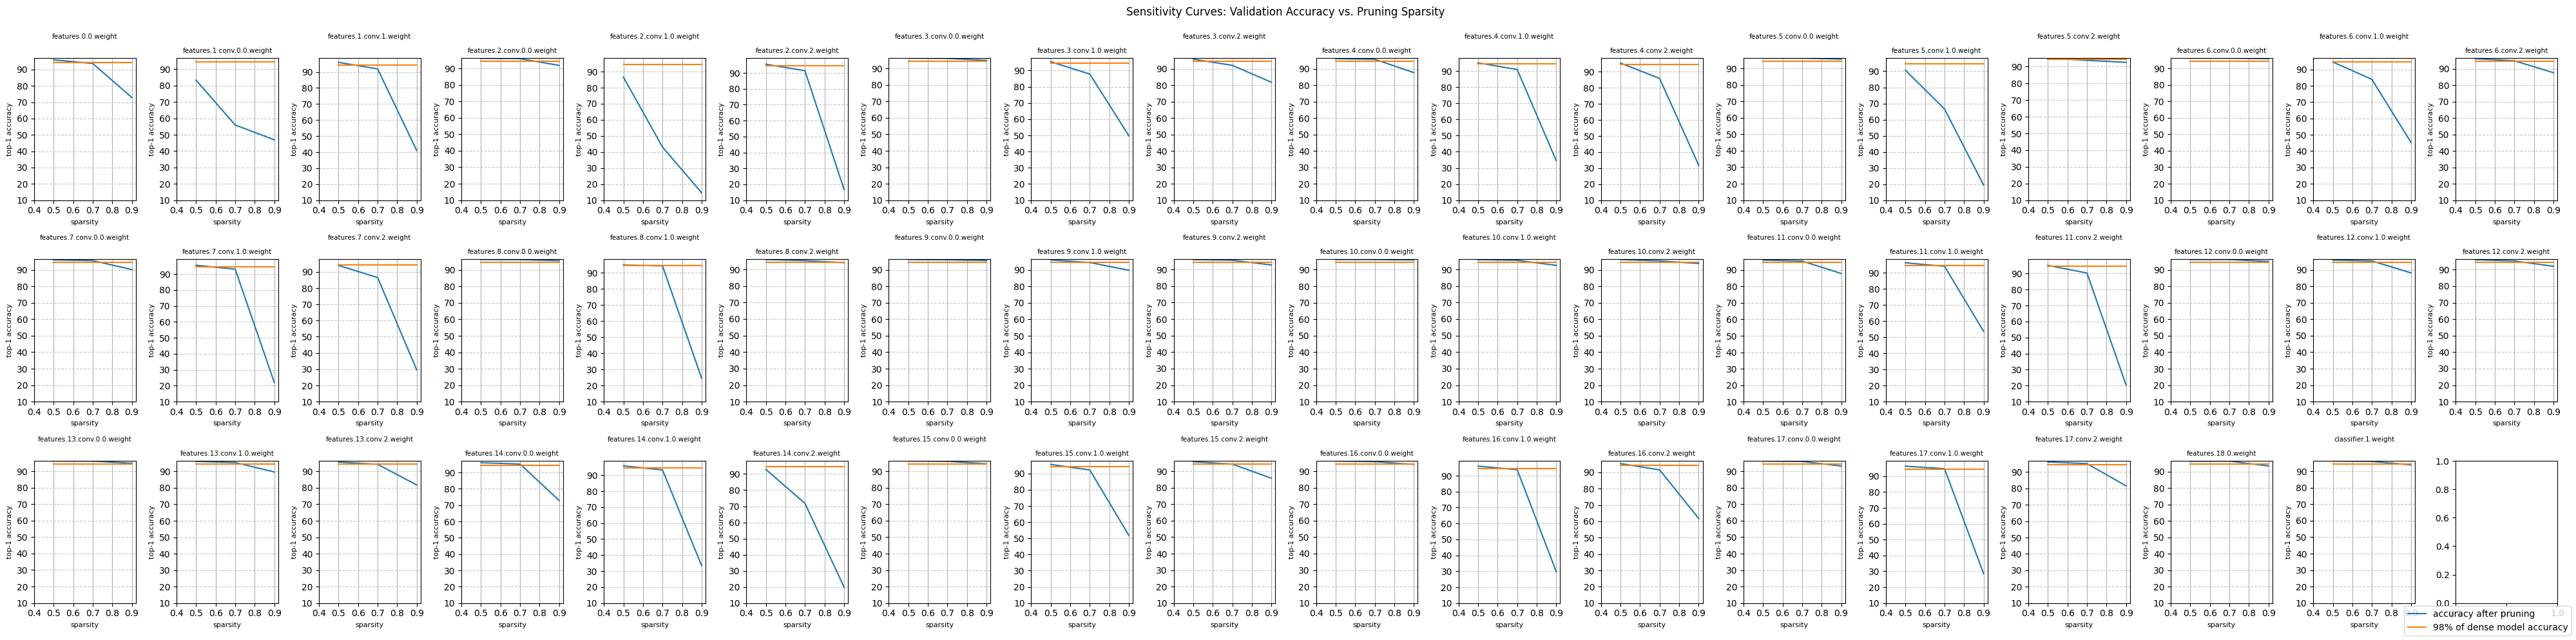

In [41]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(40,10))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_yticks(np.arange(start=10, stop=100, step=10))
            ax.tick_params(axis='both', which='major', labelsize=10)

            if plot_index % 2 == 0:
                ax.set_title(name, fontsize=7.5, y=1.1)
            else:
                ax.set_title(name, fontsize=7.5)
            ax.set_xlabel('sparsity', fontsize=8)
            ax.set_ylabel('top-1 accuracy', fontsize=8)

            ax.grid(axis='x')
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            plot_index += 1
    fig.legend([
        'accuracy after pruning',
        f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
    ], loc='lower right')
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity',)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

### Question 4 (15 pts)

Please answer the following questions using the information in the above sensitivity curves.

#### Question 4.1 (5 pts)

What's the relationship between pruning sparsity and model accuracy? (*i.e.*, does accuracy increase or decrease when sparsity becomes higher?)

**Your Answer:** Accuracy decreases as sparsity increases.

#### Question 4.2 (5 pts)

Do all the layers have the same sensitivity?

**Your Answer:** No, the layers with weights not close to zero have higher sensitivity.

#### Question 4.3 (5 pts)

Which layer is the most sensitive to the pruning sparsity?

**Your Answer:** The 'features.2.conv.1.0.weight' layer is the most sensitive.

## \#Parameters of each layer
In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

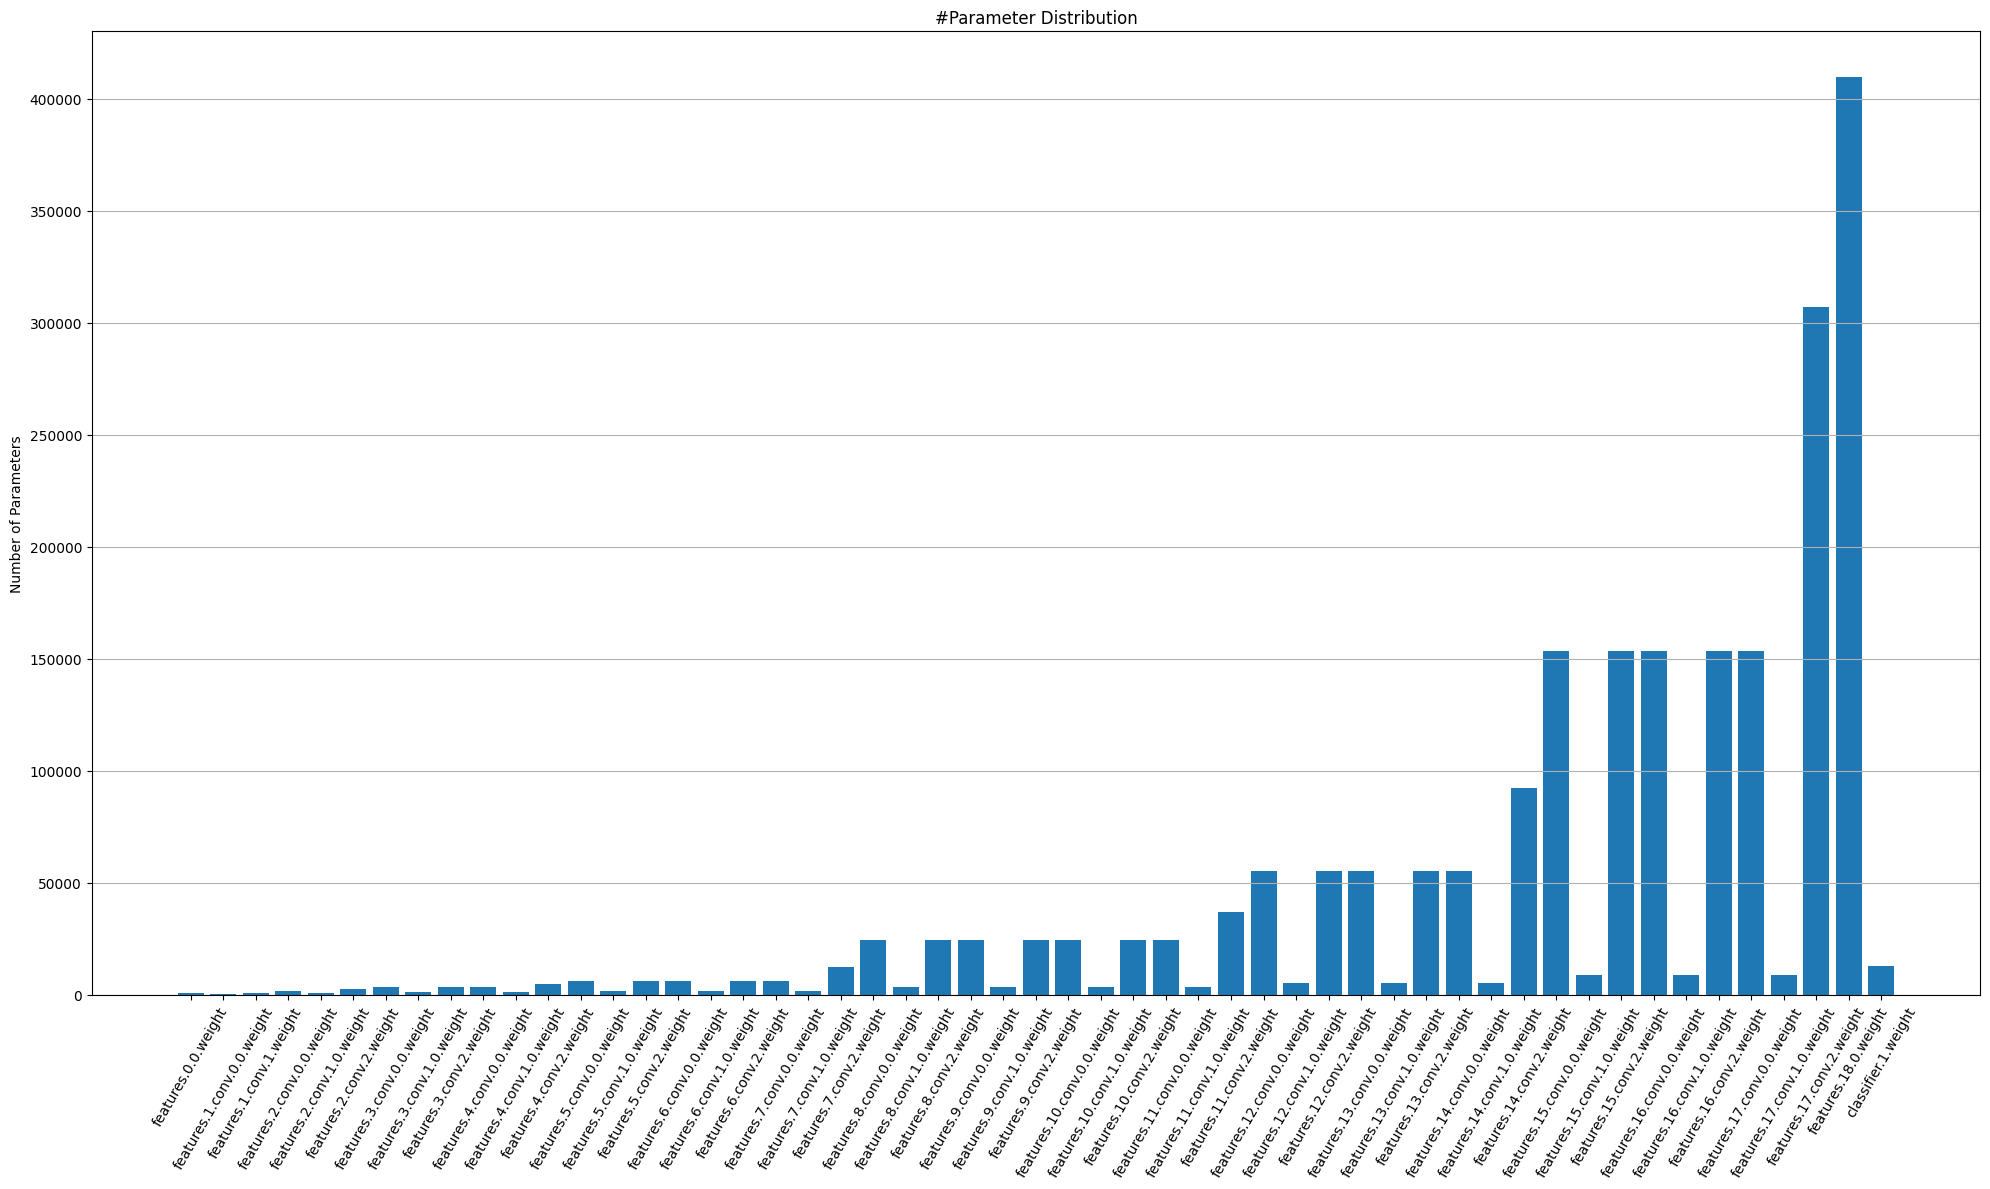

In [54]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(20, 12))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution



### Question 5 (10 pts)

Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.

**Hint**:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [99]:
import csv

# 構建 CSV 文件的數據
csv_data = []

# 添加表頭 (第一行)
header = ["name"] + [f"sparsity_{s:.2f}" for s in sparsities]
csv_data.append(header)
idx = 0
for (name, param) in model.named_parameters():
    if param.dim() > 1:
        print(idx, name, param.numel(), accuracies[idx])
        row = [name] + accuracies[idx]
        csv_data.append(row)
        idx += 1

# print(np.array(accuracies).shape)
# 將數據寫入 CSV 文件
csv_file = "sensitivity_results.csv"
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Results saved to {csv_file}")

0 features.0.0.weight 864 [95.92347717285156, 93.69992065429688, 72.8866195678711]
1 features.1.conv.0.0.weight 288 [83.29327392578125, 55.91947555541992, 46.875]
2 features.1.conv.1.weight 512 [95.95352172851562, 91.88702392578125, 40.965545654296875]
3 features.2.conv.0.0.weight 1536 [96.11378479003906, 95.94351196289062, 91.81690979003906]
4 features.2.conv.1.0.weight 864 [86.5284423828125, 43.028846740722656, 14.653446197509766]
5 features.2.conv.2.weight 2304 [95.41265869140625, 91.32612609863281, 16.716747283935547]
6 features.3.conv.0.0.weight 3456 [96.26402282714844, 96.09375, 94.911865234375]
7 features.3.conv.1.0.weight 1296 [95.43269348144531, 87.76042175292969, 49.659454345703125]
8 features.3.conv.2.weight 3456 [95.8934326171875, 92.10737609863281, 81.82091522216797]
9 features.4.conv.0.0.weight 3456 [96.20392608642578, 95.83333587646484, 87.71034240722656]
10 features.4.conv.1.0.weight 1296 [95.0821304321289, 90.96554565429688, 34.45512771606445]
11 features.4.conv.2.weig

In [55]:
def recover_model():
  model = torch.load("./mobilenetv2_0.963.pth", map_location="cpu", weights_only=False)
  model.cuda()
  return model

In [100]:
model = recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'features.0.0.weight': 0.70,
    'features.1.conv.0.0.weight': 0.30,
    'features.1.conv.1.weight': 0.70,
    'features.2.conv.0.0.weight': 0.90,
    'features.2.conv.1.0.weight': 0.30,
    'features.2.conv.2.weight': 0.70,
    'features.3.conv.0.0.weight': 0.90,
    'features.3.conv.1.0.weight': 0.50,
    'features.3.conv.2.weight': 0.70,
    'features.4.conv.0.0.weight': 0.70,
    'features.4.conv.1.0.weight': 0.70,
    'features.4.conv.2.weight': 0.50,
    'features.5.conv.0.0.weight': 0.90,
    'features.5.conv.1.0.weight': 0.50,
    'features.5.conv.2.weight': 0.90,
    'features.6.conv.0.0.weight': 0.90,
    'features.6.conv.1.0.weight': 0.50,
    'features.6.conv.2.weight': 0.70,
    'features.7.conv.0.0.weight': 0.90,
    'features.7.conv.1.0.weight': 0.70,
    'features.7.conv.2.weight': 0.50,
    'features.8.conv.0.0.weight': 0.90,
    'features.8.conv.1.0.weight': 0.70,
    'features.8.conv.2.weight': 0.90,
    'features.9.conv.0.0.weight': 0.90,
    'features.9.conv.1.0.weight': 0.70,
    'features.9.conv.2.weight': 0.90,
    'features.10.conv.0.0.weight': 0.90,
    'features.10.conv.1.0.weight': 0.90,
    'features.10.conv.2.weight': 0.90,
    'features.11.conv.0.0.weight': 0.70,
    'features.11.conv.1.0.weight': 0.70,
    'features.11.conv.2.weight': 0.70,
    'features.12.conv.0.0.weight': 0.90,
    'features.12.conv.1.0.weight': 0.70,
    'features.12.conv.2.weight': 0.90,
    'features.13.conv.0.0.weight': 0.90,
    'features.13.conv.1.0.weight': 0.70,
    'features.13.conv.2.weight': 0.70,
    'features.14.conv.0.0.weight': 0.70,
    'features.14.conv.1.0.weight': 0.70,
    'features.14.conv.2.weight': 0.50,
    'features.15.conv.0.0.weight': 0.90,
    'features.15.conv.1.0.weight': 0.70,
    'features.15.conv.2.weight': 0.70,
    'features.16.conv.0.0.weight': 0.90,
    'features.16.conv.1.0.weight': 0.70,
    'features.16.conv.2.weight': 0.70,
    'features.17.conv.0.0.weight': 0.90,
    'features.17.conv.1.0.weight': 0.70,
    'features.17.conv.2.weight': 0.70,
    'features.18.0.weight': 0.90,
    'classifier.1.weight': 0.90,
##################### YOUR CODE ENDS HERE #######################
}

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

After pruning with sparsity dictionary
  features.0.0.weight: 0.70
  features.1.conv.0.0.weight: 0.30
  features.1.conv.1.weight: 0.70
  features.2.conv.0.0.weight: 0.90
  features.2.conv.1.0.weight: 0.30
  features.2.conv.2.weight: 0.70
  features.3.conv.0.0.weight: 0.90
  features.3.conv.1.0.weight: 0.50
  features.3.conv.2.weight: 0.70
  features.4.conv.0.0.weight: 0.70
  features.4.conv.1.0.weight: 0.70
  features.4.conv.2.weight: 0.50
  features.5.conv.0.0.weight: 0.90
  features.5.conv.1.0.weight: 0.50
  features.5.conv.2.weight: 0.90
  features.6.conv.0.0.weight: 0.90
  features.6.conv.1.0.weight: 0.50
  features.6.conv.2.weight: 0.70
  features.7.conv.0.0.weight: 0.90
  features.7.conv.1.0.weight: 0.70
  features.7.conv.2.weight: 0.50
  features.8.conv.0.0.weight: 0.90
  features.8.conv.1.0.weight: 0.70
  features.8.conv.2.weight: 0.90
  features.9.conv.0.0.weight: 0.90
  features.9.conv.1.0.weight: 0.70
  features.9.conv.2.weight: 0.90
  features.10.conv.0.0.weight: 0.90
  fea

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Sparse model has accuracy=10.02% before fintuning


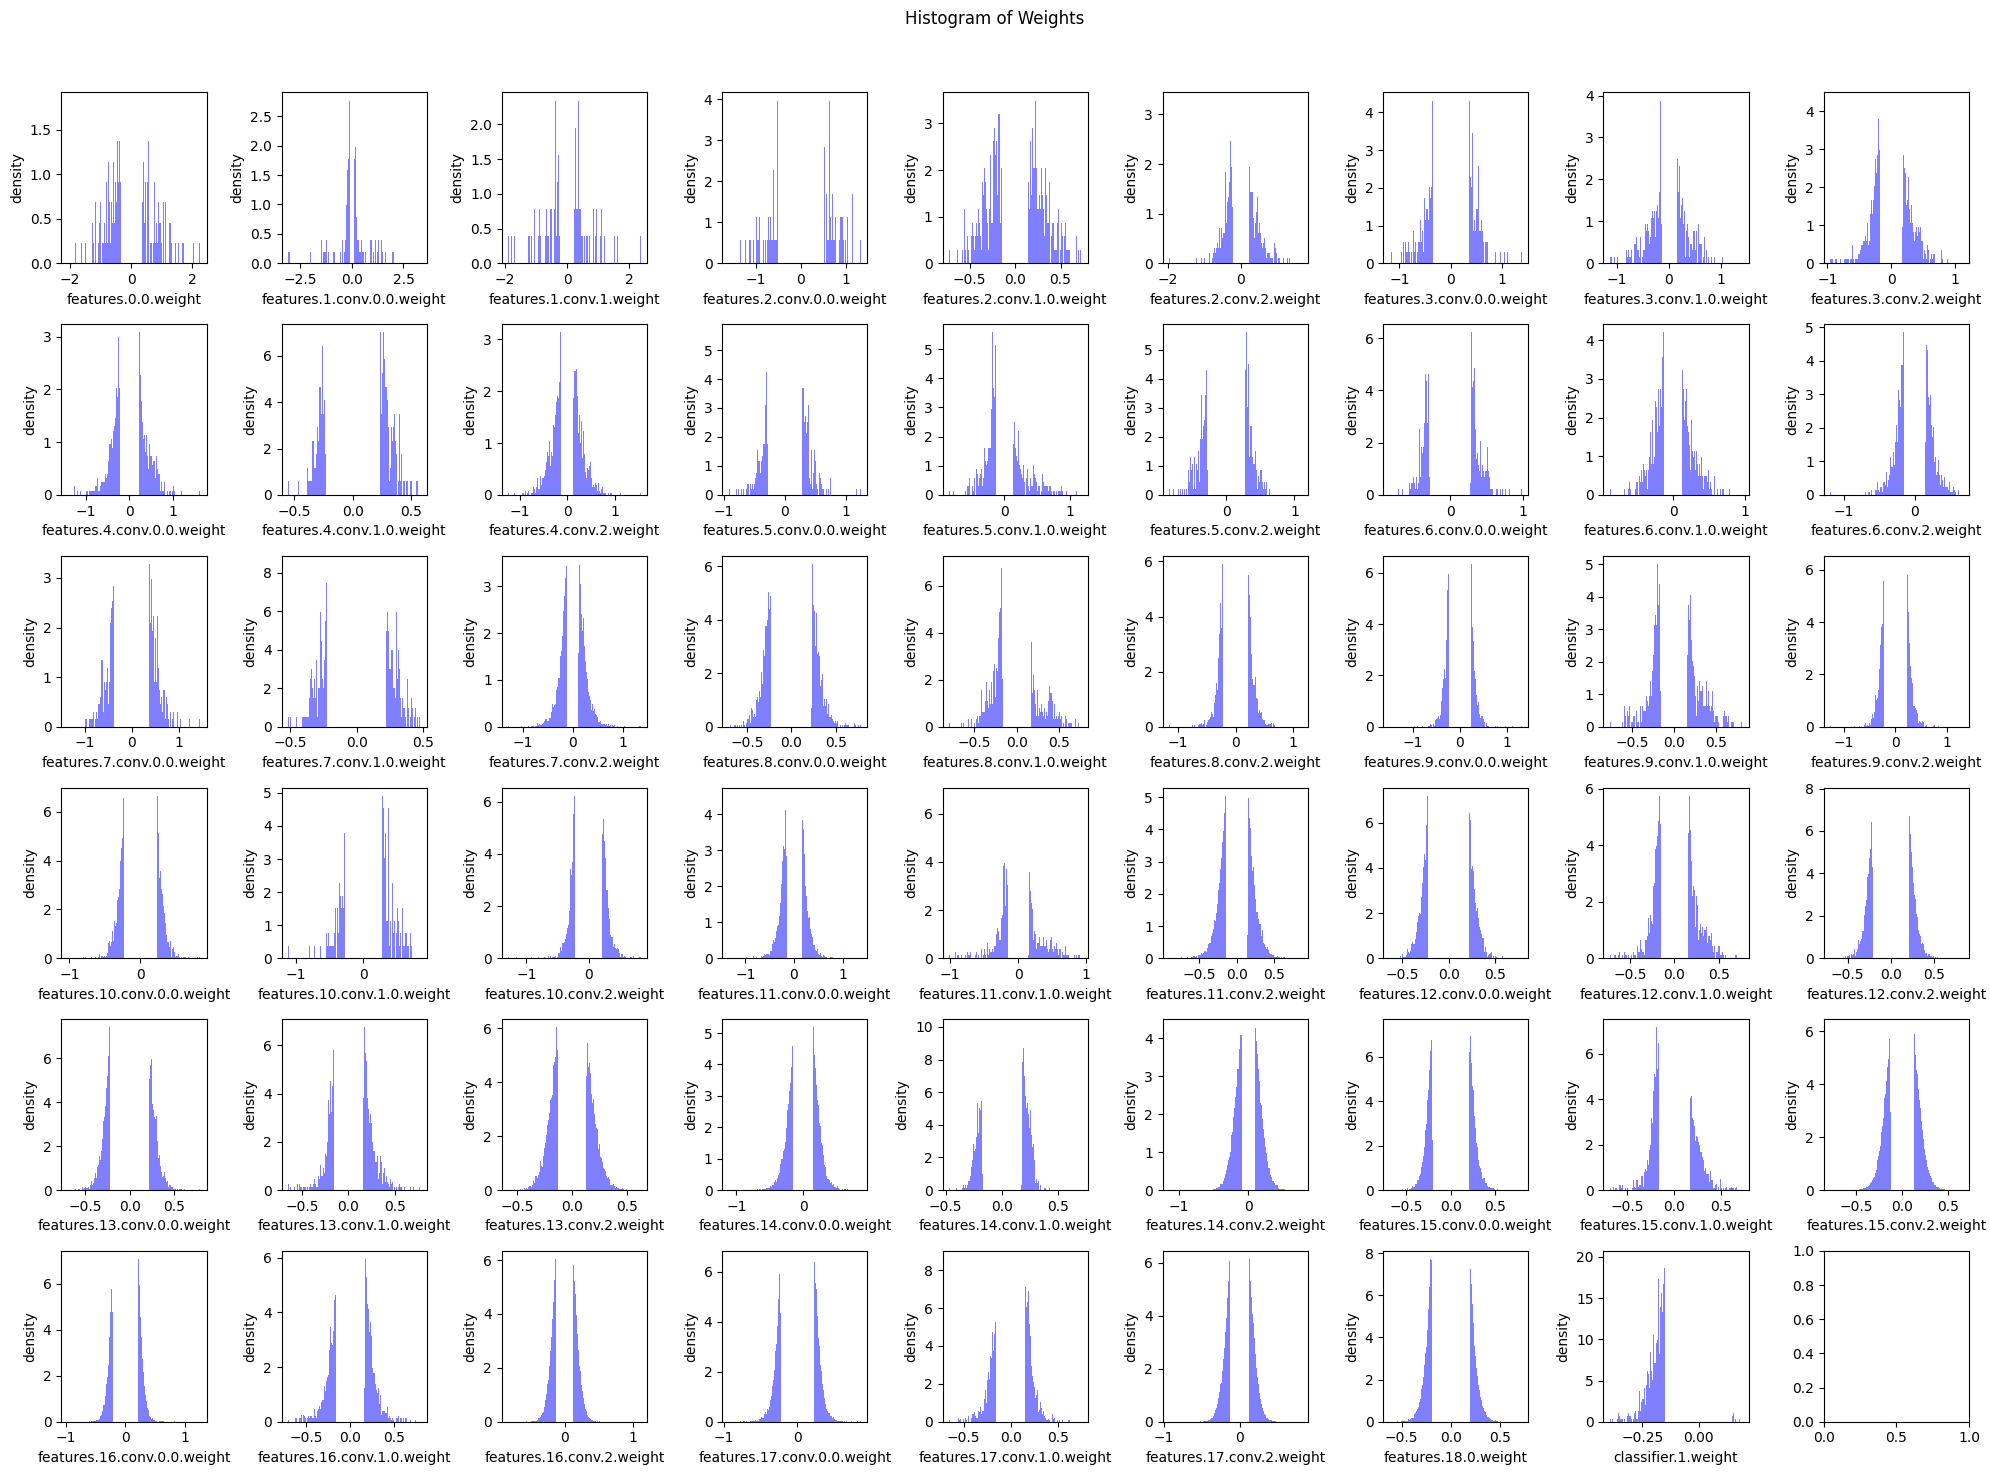

In [101]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

## Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

In [102]:
# Your can apply your own hyper parameter and do fine-tuning

num_finetune_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
            callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 1 Accuracy 80.83% / Best Accuracy: 80.83%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 2 Accuracy 84.50% / Best Accuracy: 84.50%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 3 Accuracy 87.02% / Best Accuracy: 87.02%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 4 Accuracy 87.75% / Best Accuracy: 87.75%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 5 Accuracy 87.88% / Best Accuracy: 87.88%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 6 Accuracy 89.42% / Best Accuracy: 89.42%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 7 Accuracy 89.59% / Best Accuracy: 89.59%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 8 Accuracy 89.24% / Best Accuracy: 89.59%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 9 Accuracy 90.08% / Best Accuracy: 90.08%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 10 Accuracy 89.68% / Best Accuracy: 90.08%


Run the following cell to see the information of best finetuned sparse model.

In [103]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=1.80 MiB = 21.11% of dense model size


eval:   0%|          | 0/156 [00:00<?, ?it/s]

Sparse model has accuracy=90.08% after fintuning


# Part 2: Channel Pruning Using Torch-Pruning

Channel pruning removes an entire channel at a time, which maintains structured shape, achieving inference speedup on GPUs and edge devices.

In this section, you will perform channel pruning on MobileNetV2 using the library [Torch-Pruning](https://github.com/VainF/Torch-Pruning).

This library captures the dependencies between adjacent model layers, which allows us to perform consistent structural pruning easily.

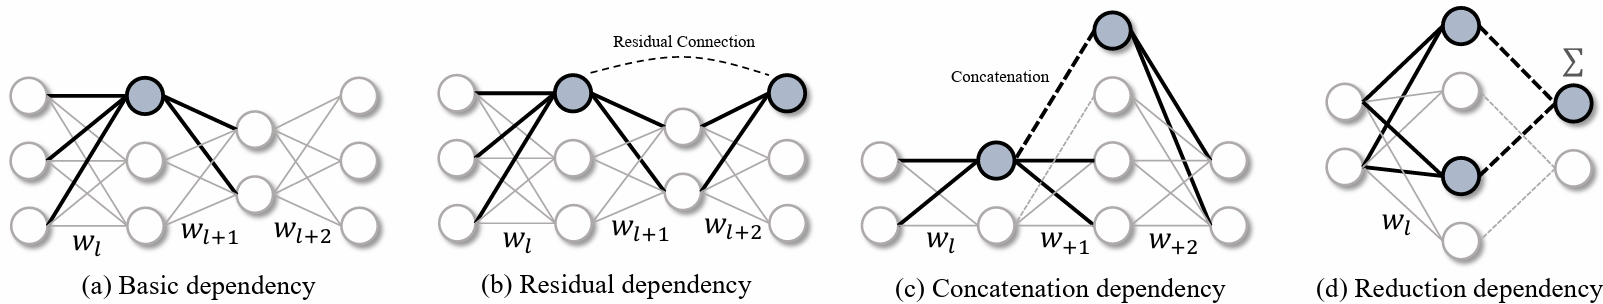

## Prune MobileNetV2 (45%+)

In this part, you will need to visit [Torch-Pruning](https://github.com/VainF/Torch-Pruning), and prune your MobileNetV2 with this library.

In this lab, you will need to submit ***mobilenet.pth*** to e3. Refer to [Hand In Policy](https://hackmd.io/@ccyangus/S1vhEooKkg#Hand-In-Policy) in lab1 hackmd.


* Obtain the number of MFLOPs of your pruned model using the provided code snippet:
  ```python
  import torch
  import torch_pruning as tp
  from torchvision.models import mobilenet_v2

  model = torch.load('./model/mobilenet.pth', map_location="cpu", weights_only=False)
  example_inputs = torch.zeros(1, 3, 224, 224).to(args.device)
  ops, size = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)

  MFLOPs = ops/1e6
  print(MFLOPs)
  ```

Your score for **Part 2** depends on your pruned model's accuracy and MFLOP.

<br>

**The grading formula is as follows:**
$$
  Score = (\dfrac{200 - MFLOPs}{200 - 45} - 10\times Clamp(0.92-Accuracy,\ 0,\ 1)) \times 45\%
$$

It is possible to obtain a score higher than 45%.

**Hint: Refer to Torch-Pruning's [example](https://github.com/VainF/Torch-Pruning/blob/master/examples/notebook/0%20-%20QuickStart.ipynb), and start from their High-level Pruners will make your life much easier.**

<br>

* Save the pruned model using the following snippet:
```python
import torch
torch.save(pruned_model, "mobilenet.pth")
```

<br>

* You can observe the speedup in ***Inference speed comparison*** section:

#### High-level Pruners

In [1]:
import torch
import copy
import torch.nn as nn
import torch_pruning as tp
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10
from torch.optim import *
from torch.optim.lr_scheduler import *
from tqdm.auto import tqdm

In [2]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  pruner: tp.MetaPruner,
  callbacks = None
) -> None:
  model.train()
  pruner.update_regularizer() # <== initialize regularizer

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()
    pruner.regularize(model)
    
    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [3]:
transform = {
    "train": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transform[split],
  )

# You can apply your own batch_size
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=64,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
    drop_last=True
  )

Files already downloaded and verified
Files already downloaded and verified


In [4]:
 # prepare your model and example inputs
model = torch.load("./mobilenetv2_0.963.pth", map_location="cpu", weights_only=False)
model.cuda()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
# print(model)
example_inputs = torch.randn(1,3,224,224).cuda()
base_macs, base_nparams = tp.utils.count_ops_and_params(model, example_inputs)

# 0. importance criterion for parameter selections
imp = tp.importance.MagnitudeImportance(p=2, group_reduction='mean')

# 1. ignore some layers that should not be pruned, e.g., the final classifier layer.
ignored_layers = []
for m in model.modules():
    if isinstance(m, torch.nn.Linear) and m.out_features == 10:
        ignored_layers.append(m) # DO NOT prune the final classifier!

        
# 2. Pruner initialization
iterative_steps = 5 # You can prune your model to the target pruning ratio iteratively.
pruner = tp.pruner.GroupNormPruner(
# pruner = tp.pruner.MagnitudePruner(
    model, 
    example_inputs, 
    global_pruning=True, # If False, a uniform ratio will be assigned to different layers.
    importance=imp, # importance criterion for parameter selection
    iterative_steps=iterative_steps, # the number of iterations to achieve target ratio
    pruning_ratio=0.5, # remove 50% channels, ResNet18 = {64, 128, 256, 512} => ResNet18_Half = {32, 64, 128, 256}
    round_to=8,
    ignored_layers=ignored_layers,
)

num_finetune_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterative_steps)
criterion = nn.CrossEntropyLoss()
best_sparse_model_checkpoint = dict()
best_accuracy = 0

for i in range(iterative_steps):
    # 3. the pruner.step will remove some channels from the model with least importance
    pruner.step()
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    
    # 4. Fintuning the model
    for epoch in range(num_finetune_epochs):
      train(model, dataloader['train'], criterion, optimizer, scheduler, pruner)
      accuracy = evaluate(model, dataloader['test'])
      is_best = accuracy > best_accuracy
      if is_best:
          best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
          best_accuracy = accuracy
      print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

    MFLOPs = macs/1e6
    print("Iter %d/%d, Params: %.2f M => %.2f M, MACs: %.2f G => %.2f G, MFLOPs: %.2f => %.2f" 
          % (i+1, iterative_steps, base_nparams / 1e6, nparams / 1e6, base_macs / 1e9, macs / 1e9, base_macs/1e6, MFLOPs))
    print(f'Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

# prunrd_model_size = get_model_size(model)
# print(f"prunrd model has size={prunrd_model_size/MiB:.2f} MiB")
# torch.save(best_sparse_model_checkpoint, "prunrded_mobilenet_{%2f.pth")

eval:   0%|          | 0/156 [00:00<?, ?it/s]

dense model has accuracy=96.30%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1 Accuracy 35.34% / Best Accuracy: 35.34%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2 Accuracy 35.14% / Best Accuracy: 35.34%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3 Accuracy 35.88% / Best Accuracy: 35.88%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4 Accuracy 35.06% / Best Accuracy: 35.88%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 5 Accuracy 35.82% / Best Accuracy: 35.88%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 6 Accuracy 35.28% / Best Accuracy: 35.88%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 7 Accuracy 35.90% / Best Accuracy: 35.90%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 8 Accuracy 35.65% / Best Accuracy: 35.90%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 9 Accuracy 35.81% / Best Accuracy: 35.90%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 10 Accuracy 36.01% / Best Accuracy: 36.01%
Iter 1/5, Params: 2.24 M => 2.06 M, MACs: 0.32 G => 0.21 G, MFLOPs: 318.97 => 214.66
Accuracy 36.01% / Best Accuracy: 36.01%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1 Accuracy 20.70% / Best Accuracy: 36.01%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2 Accuracy 21.29% / Best Accuracy: 36.01%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3 Accuracy 20.85% / Best Accuracy: 36.01%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4 Accuracy 20.70% / Best Accuracy: 36.01%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 5 Accuracy 20.90% / Best Accuracy: 36.01%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 6 Accuracy 21.05% / Best Accuracy: 36.01%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 7 Accuracy 20.94% / Best Accuracy: 36.01%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 8 Accuracy 20.97% / Best Accuracy: 36.01%


train:   0%|          | 0/781 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Pruning with DepGraph

In [ ]:
import torch
import torch_pruning as tp

# 0. prepare your model and example inputs
model = torch.load("./mobilenetv2_0.963.pth", map_location="cpu", weights_only=False)
print(model)
example_inputs = torch.randn(1,3,224,224)

# 1. build dependency graph 
DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)
# print(DG)
# 2. Select some channels to prune. Here we prune the channels indexed by [2, 6, 9].
# pruning_idxs = pruning_idxs=[2, 6, 9]
# pruning_group = DG.get_pruning_group( model.conv1, tp.prune_conv_out_channels, idxs=pruning_idxs )

# 3. prune all grouped layer that is coupled with model.conv1
# if DG.check_pruning_group(pruning_group):
#     pruning_group.prune()


### Score Calulator
Fill in your model's accuracy and MFLOPs below to obtain your score.

*The score shown below is for reference purpose only. Your final score will be evaluated by TAs through the model's weight you submit.*

In [19]:
Accuracy = accuracy/100
# MFLOPs = 92

score = max(0, (200-MFLOPs)/(200-45) - 10*min(max(0.92-Accuracy, 0), 1)) * 45
print("Your Score: {:0.2f}/45".format(score))

Your Score: 0.00/45


### Describe your approach to pruning MobileNetV2 (5%)

Please detail your method for pruning MobileNetV2 to achieve the final model. Include the following:

* The specific pruning technique used.
* Steps taken to prune and then retrain the model.
* The most effective strategy you discovered for achieving the best result.

(Top methodologies, based on achieved score, will be showcased by TAs in DC as a learning resources for the class.)

**Your Answer:**

### Inference speed comparison

In [ ]:
model = torch.load('./mobilenetv2_0.963.pth', map_location="cpu", weights_only=False)
pruned_model = torch.load('./mobilenet.pth', map_location="cpu", weights_only=False)

In [ ]:
model.cuda()
pruned_model.cuda()
model_accuracy = evaluate(model, dataloader['test'])
model_size = get_model_size(model)
print(f"dense model has accuracy={model_accuracy:.2f}%")
print(f"dense model has size={model_size/MiB:.2f} MiB")

pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
pruned_model_size = get_model_size(pruned_model)
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")
print(f"pruned model has size={pruned_model_size/MiB:.2f} MiB")

In [ ]:
model.eval()
model.to('cpu')
start_time = time.time()
for inputs, targets in tqdm(dataloader['test'], desc="eval", leave=False,
                          disable=False):
    outputs = model(inputs)
end_time = time.time()
inference_time = end_time - start_time
print(f"Original inference time: {inference_time:.4f} seconds")

In [ ]:
pruned_model.eval()
pruned_model.to('cpu')
start_time = time.time()
for inputs, targets in tqdm(dataloader['test'], desc="eval", leave=False,
                          disable=False):
    outputs = pruned_model(inputs)
end_time = time.time()
pruned_inference_time = end_time - start_time
print(f"Pruned inference time: {pruned_inference_time:.4f} seconds")

In [ ]:
print(f'Speedup: {inference_time / pruned_inference_time}x')

### You've finished lab1
### Congratulations! :-)